## Heuristic 1
### Description

If a deposit address matches a withdraw address, then it is trivial to link the two addresses. Therefore, the deposit address needs to be removed from all the other withdraw addresses’ anonymity set. If a number $N$ of deposits with a same address $add1$, and a number $M$ ($M < N$) of withdraws with that same aaddress are detected, then a number $M - N$ of deposit transactions must be removed from the anonimity set of all the other withdraw transactions.

In [1]:
# Import relevant packages.

using DataFrames
using CSV
using StatsPlots
using ProgressBars

In [2]:
# Environment settings for the notebook.
ENV["LINES"]=10
ENV["COLUMNS"]=10000;

In [3]:
# Load withdraw and deposit transactions data.

withdraw_transactions_df = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
withdraw_transactions_df[!, "recipient_address"] = lowercase.(withdraw_transactions_df[!, "recipient_address"])

deposit_transactions_df = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame);

### Function summary: addresses_to_transactions

Given a transactions DataFrame, returns a dictionary with the unique addresses of the transactions data as keys and a list of tuples as values. The tuples consist on the hash of the transaction with the address as the corresponding key in the first index, the timestamp of the transaction in the second index and the tornado cash pool that the address is interacting with in that specific transaction.

For example, if the address 0x6c6e4816ecfa4481472ff88 has made transaction with a hash 0x7f851ba1d7292ca565961073a111 that interacted with the 0.1 ETH pool at timestamp 1, and another transaction with hash 0x8f851ba1d7192ca565961073a9191 that interacted with the 1ETH pool at timestamp 2, then the dictionary returned will be:

```
{"0x6c6e4816ecfa4481472ff88": [("0x7f851ba1d7292ca565961073a111", timestamp1, "0x12D66f87A04A9E220743712cE6d9bB1B5616B8Fc"), ("0x8f851ba1d7192ca565961073a9191", timestamp2, "0x47CE0C6eD5B0Ce3d3A51fdb1C52DC66a7c3c2936")]
```

Note that "0x47CE0C6eD5B0Ce3d3A51fdb1C52DC66a7c3c2936" is the 1 ETH address and "0x12D66f87A04A9E220743712cE6d9bB1B5616B8Fc" the one of 0.1 ETH pool

In [4]:
withdraw_transactions_df

,Column1,Unnamed: 0,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address,recipient_address
,Int64,Int64,String,Int64,Int64,String,String,Int64,Int64,Int64,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Float64?,Float64?,Float64?,Int64,String,String
1,0,7,0x3dc8617176f45c0f33a95589c202b22f9ba8aa7067bb92887517e20b237907e3,789,196,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0xa160cdab225685da1d56aa342ad8841c3b53f291,0,386384,121000000000,10382378,336384,missing,missing,1,2020-10-05 07:57:28 UTC,10994498,0xa96abb653dd6d4e3cedd6bd65fd0a7b034e4c9527be91cb80ee62d790714ab49,missing,missing,missing,121000000000,0xa160cdab225685da1d56aa342ad8841c3b53f291,0xd843ce0f9da3bd30537b9850711ab8089e06b4cf
2,1,8,0x3199144ba98021e523c5ec1e4f4dcf64446d69b825da7251d2d2a0a794038d0d,9,190,0xb77562124be8ac967cf7fc24573fe252aa39d95d,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13000000000,7303106,339456,missing,missing,1,2020-02-11 19:10:54 UTC,9463504,0x1e1dc9cec82d1dcd0e68e60968d180408007e148ac065261de232dc502dfb756,missing,missing,missing,13000000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0xb77562124be8ac967cf7fc24573fe252aa39d95d
3,2,9,0x95a46a1305ddc8b7e01d82c7d6766fce4713c085929f70c9a24e90f927672699,2,81,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0,439456,13200000000,3211601,339456,missing,missing,1,2020-02-16 16:05:14 UTC,9495139,0x1f0562c98f40f0689ed8bac422b4714289bd452d9290928b30f7defe0943381f,missing,missing,missing,13200000000,0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d,0x0e54db73f82bd9fde34ebce53ea83bd197e9044c
4,3,13,0x172a0a1618aa6c1f9f27a370236d8c91156fd6192ad11b91faa77bb852599b76,2024,189,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,384581,40000000000,11795370,343296,missing,missing,1,2020-11-09 17:08:00 UTC,11224582,0xe0ae8902495001fc28025238a74703c1b3d58282aaeef5fd5ca3fe9cb2d273ff,missing,missing,missing,40000000000,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x42a9cf901e889ca8a685394854c27898dbff86b0
5,4,15,0x30becee80e63a039102df3b1243e5d314534abfcf3ed0fc4eadb2dc5b1c45ab7,2350,127,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,404304,15020000842,9771737,354304,missing,missing,1,2020-11-29 01:18:57 UTC,11350558,0x4d8f724d2bdffa546cef74d21c6c43968b566b67318e2f737a7c6b26b8781e56,missing,missing,missing,15020000842,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0xc9fb4b16800e61076326145e1066e876cf9f7a7b
6,5,16,0x5ef2e6d75efa800f009a84b27ae22609597edee8df8ee8699c004af233cf5855,999,120,0x2d50dbcc960bec854227f51f8074e1da28bd4a37,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,404304,72000000000,8783549,354304,missing,missing,1,2020-10-11 18:09:09 UTC,11035787,0xb18729068418804f6c247b13e92236035f8303c43828c59d70b279166ca4f67a,missing,missing,missing,72000000000,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x9453663da4123648bd00cb5600b97a4314ad0058
7,6,17,0x59d6d259118b41170550e5662c35b20c1b8ba795e420f6ce7a74772a9a834492,550,86,0x41a28335c5075c81502a97cebad597f28728a815,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0,404304,26000000000,4476696,354304,missing,missing,1,2020-05-26 22:55:55 UTC,10144176,0xd22e4252818d56d9a7b4bb6c7488842877db42771a497f175ba78cd7a1aa00c1,missing,missing,missing,26000000000,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0xd01ad76a2337354dd458fcbb6e507e001f06b77d
8,7,42,0x805b2ae79b5267a23e6c79d3324d43dae0f64e81f77f166c09dca9ff46cfc955,260,128,0xefab18983029d2ba840e34698efb67fdf8120711,0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc,0,383057,5050000000,7284273,333057,missing,missing,1,2020-02-04 13:43:11 UTC,9416438,0x644ea6d8f078b89696758c59f74f93f0f226838593a79bcb9980f5815e023cbb,missing,missing,missing,5050000000,0x12d66f87a04a9e22074

In [5]:
function addresses_to_transactions(transactions_df)
    
    # Initialize empty dictionary to store addresses and associated transactions.
    
    address_to_transactions_dict = Dict{String, Vector{Tuple{String, String, String}}}()
    
    # We iterate over every transaction in the transactions DataFrame.
    
    for row in ProgressBar(eachrow(transactions_df),  printing_delay=5)

        """
        We check if the address of the current transaction in the iteration is already in the 
        dictionary. If it isn't, then we initialize that key and the list with the tuple. The
        tuple will consist of the hash and the timestamp of the current transaction.
        
        If the key already exists, we append to the associated list the tuple of the hash and
        timestamp of the current transaction.
        """
         
        if row.from_address ∉ Set(keys(address_to_transactions_dict))
            address_to_transactions_dict[row.from_address] = [(row.hash, row.block_timestamp, row.tornado_cash_address)]
            #println("if")
        else
            #println(address_to_transactions_dict[row.from_address])
            push!(address_to_transactions_dict[row.from_address], (row.hash, row.block_timestamp, row.tornado_cash_address) )
        # The dictionary with the addresses and transactions is returned.
        end
    
    end
    
    return address_to_transactions_dict
end

addresses_to_transactions (generic function with 1 method)

### Function summary: same_deposit_and_recipient_addresses_heuristic

The function receives a particular withdraw transaction and a dictionary corresponding to what is returned by function addresses_to_transactions.

It returns a tuple:

* (True, list_of_same_address_deposit_hashes): When same address deposits are found, this tuple is returned. In the first element a boolean true, and the second is a list with all the deposit hashes that verify having the same address as the withdraw transaction.

* (False, None): When no such deposit was found

In [6]:
function same_deposit_and_recipient_address_heuristic(withdraw_transaction, deposit_addresses_to_transactions)
    
    """
    Check if the address of the withdraw tx is in the deposit_addresses_to_transactions keys.
    If it is, then a list is created with the hashes of all the deposit txs with the same address and
    with an earlier timestamp than the withdraw tx.
    If the address is not in the deposit_addresses_to_transactions dictionary, (False, None) is returned.
    """
    
    if withdraw_transaction.recipient_address in Set(keys(deposit_addresses_to_transactions))
        
        # Only the transactions with earlier timestamps and same pool are selected for the list same_deposit_address_hashes.
        same_deposit_address_hashes = [tx_hash[1] for tx_hash in deposit_addresses_to_transactions[withdraw_transaction.recipient_address] if (tx_hash[2] <= withdraw_transaction.block_timestamp) && (tx_hash[3] == withdraw_transaction.tornado_cash_address)]
   
        # Final check to assert that list is not empty.
        if length(same_deposit_address_hashes) > 0
            return (true, same_deposit_address_hashes)
        else
            return (false, nothing)
        end
        
    end
        
    return (false, nothing)
end

same_deposit_and_recipient_address_heuristic (generic function with 1 method)


### Function summary: apply_same_deposit_and_recipient_addresses_heuristic

Receives the withdraw and deposit transactions, and applies the first heuristic for each withdraw transaction. Returns a dictionary, with keys as the hash of each withdraw transaction were a same deposit address was detected. The values are the hashes of all deposits matching this criteria.


In [7]:
function apply_same_deposit_and_recpient_address_heuristic(withdraw_transactions_df, deposit_transactions_df)
    
    # Initialize an empty dictionary for storing the links between withdraw hashes and deposit hashes with the 
    # same address.
    
    deposit_addresses_and_transactions = addresses_to_transactions(deposit_transactions_df)
    
    same_deposit_address_hashes = Dict()
    
    # Iterate over the withdraw transactions and apply heuristic one. For each withdraw with matching deposit
    # transactions, a new element is added to the dictionary with the key as the withdraw hash and the values
    # as all matching deposit hashes.
        
    for withdraw_row_tuple in ProgressBar(eachrow(withdraw_transactions_df), printing_delay=5)
        deposit_hashes = same_deposit_and_recipient_address_heuristic(withdraw_row_tuple, deposit_addresses_and_transactions)
        if deposit_hashes[1]
            same_deposit_address_hashes[withdraw_row_tuple.hash] = deposit_hashes[2]
        end

    end
    
    # Return the dictionary with the links
    return same_deposit_address_hashes
end

apply_same_deposit_and_recpient_address_heuristic (generic function with 1 method)

In [8]:
hashes_dict = apply_same_deposit_and_recpient_address_heuristic(withdraw_transactions_df, deposit_transactions_df);

0.0%┣                                     ┫ 0/97.4k [00:05<-135:-13:-46, -5s/it]
0.0%┣                                        ┫ 1/97.4k [00:05<Inf:Inf, InfGs/it]
18.4%┣██████▉                              ┫ 17.9k/97.4k [00:10<00:46, 1.7kit/s]
27.7%┣██████████▎                          ┫ 27.0k/97.4k [00:15<00:40, 1.8kit/s]
33.9%┣████████████▌                        ┫ 33.0k/97.4k [00:20<00:40, 1.6kit/s]
39.1%┣██████████████▌                      ┫ 38.0k/97.4k [00:25<00:39, 1.5kit/s]
43.8%┣████████████████▏                    ┫ 42.6k/97.4k [00:30<00:39, 1.4kit/s]
48.0%┣█████████████████▊                   ┫ 46.8k/97.4k [00:35<00:38, 1.3kit/s]
52.1%┣███████████████████▎                 ┫ 50.7k/97.4k [00:40<00:37, 1.3kit/s]
56.0%┣████████████████████▊                ┫ 54.5k/97.4k [00:45<00:36, 1.2kit/s]
59.7%┣██████████████████████               ┫ 58.1k/97.4k [00:50<00:34, 1.2kit/s]
63.1%┣███████████████████████▍             ┫ 61.5k/97.4k [00:55<00:32, 1.1kit/s]
66.4%┣██████████████████████

In [9]:
linked_deposits_count = map( x -> length(x), values(hashes_dict))

14284-element Vector{Int64}:
 200
  30
 135
   ⋮
   5
   5

In [10]:
length(linked_deposits_count)

14284

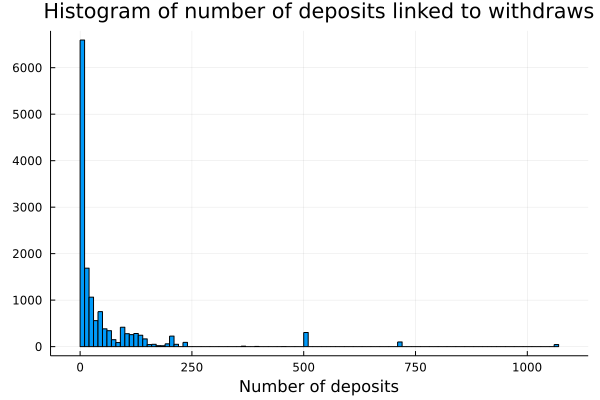

In [11]:
histogram(linked_deposits_count, bins=100, label = false)
title!("Histogram of number of deposits linked to withdraws")
xlabel!("Number of deposits")

## Heuristic 2

### Description

If there is a deposit and a withdraw transaction with **unique** gas prices (e.g., 3.1415926 Gwei), then we consider the deposit and the withdraw transactions linked. The corresponding deposit transaction can be removed from any other withdraw transaction’s anonymity set.

### Getting the data
We obtain the data using Google Big Query.
In order to obtain the deposits and withdrawals transactions, just run the following querys:

### Withdrawals 
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE `to_address` 
IN (SELECT `address` FROM `tornado_cash_transactions.tornadocontracts`) AND SUBSTR(`input`, 1, 10) = "0x21a0adb6";

### Deposits
SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions` WHERE `to_address` 
IN (SELECT `address` FROM `tornado_cash_transactions.tornadocontracts`) AND SUBSTR(`input`, 1, 10) = "0xb214faa5";

References here:
https://github.com/Phread420/tornado_bigquery/blob/main/Notes.md

This results are stored in the following files:
- withdraw_transactions.csv
- deposit_transactions.csv

After obtaining those two files, the next thing to do is to get the "recipient_addresses" that are making the withdrawl (if the user withdraws via a relayer, the relayer's account will be displayed in the "from_addres" field). That information is encoded in the "input" field of the withdrawal transactions.

The process to do so is in the following notebook:
https://github.com/lambdaclass/tornado_cash_anonymity_tool/blob/main/notebooks/complete_withdraw_data_set.ipynb

Note that the recipient addresses obtained in this df are in upper case and the addresses coming from the big query are in lower case, so you have to make the transformation when running the heuristic.

In [12]:
using DataFrames
using CSV
using ProgressBars

In [13]:
ENV["COLUMNS"]=10000
ENV["LINES"]=10;

In [14]:
withdraw_transactions_df = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
deposit_transactions_df = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame)

non_relayer_withdraw_transactions_df = filter(row -> row.from_address == row.recipient_address, withdraw_transactions_df);

### Function summary: filter_by_unique_gas_price

Given a transactions DataFrame, it returns a dictionary with the unique gas prices as keys and a tuple containing the hash of that transaction and the timestamp. For example,

```
{111000302: ("0x387fcd87a", timestamp1)
```

In [15]:
# Filters a transaction DataFrame, leaving only the rows that have unique gas_price.

function filter_by_unique_gas_price(transactions_df)
    unique_gas_prices = filter(row -> row.count==1, combine(groupby(transactions_df, :gas_price), nrow => :count))[!, "gas_price"]
    temp_df = filter(row -> row.gas_price ∈ unique_gas_prices, transactions_df)
    
    
    return Dict{Int, Tuple{String,String}}(
            (row.gas_price) => (row.hash, row.block_timestamp) for row in eachrow(temp_df)
            )

end

filter_by_unique_gas_price (generic function with 1 method)

### Function summary: filter_by_unique_gas_price_by_pool

Given a transactions DataFrame, it returns a dictionary with a tuple of the unique gas prices and tornado pool as keys and a tuple containing the hash of that transaction and the timestamp. For example, 

```
{(111000302, "0x24387248"): ("0x387fcd87a", timestamp1)

```

In [16]:
function filter_by_unique_gas_price_by_pool(transactions_df)
    unique_gas_prices_by_pool = filter(row -> row.count==1, combine(groupby(transactions_df, [:gas_price , :tornado_cash_address]), nrow => :count))[!, ["gas_price", "tornado_cash_address"]]
    
    
    # Tuple set with the values (gas_price, tornado_cash_address) is made to filter efficiently
    
    tuple_set = Set{Tuple{Int, String}}([(row.gas_price, row.tornado_cash_address) for row in eachrow(unique_gas_prices_by_pool)])
    
    # A dataframe of the transactions that verify having these unique gas price values by pool.
    
    temp_df = filter(iter_tuple -> (iter_tuple.gas_price, iter_tuple.tornado_cash_address) in tuple_set , deposit_transactions_df)
    
    # The DataFrame is transformed to a dictionary with only the relevant information.
    
    return Dict{Tuple{Int,String}, Tuple{String,String}}((row.gas_price, row.tornado_cash_address) => (row.hash, row.block_timestamp) for row in eachrow(temp_df))
end

filter_by_unique_gas_price_by_pool (generic function with 1 method)

### Function summary: same_gas_price_heuristic

This function receives a particular withdraw transaction and a dictionary with the unique gas price deposits, as returned by the function filter_by_unique_gas_price.

It returns a tuple:
* $(True, deposit$ $hash)$ when a deposit transaction with the same gas price as the withdrawal transaction is found.
* $(False, None)$ when such a deposit is not found.

In [17]:
function same_gas_price_heuristic(withdrawal_transaction, unique_gas_price_deposit_dict)
    
    """
    Check if the gas price of the given withdrawal transaction is within the dictionary keys and that
    the deposit was made earlier than the withdral.
    If it is, then a tuple is returned, (True, deposit_hash).
    If it is not, (False, None) is returned.
    """
    
    if withdrawal_transaction.gas_price in Set(keys(unique_gas_price_deposit_dict)) && (unique_gas_price_deposit_dict[withdrawal_transaction.gas_price][2] < withdrawal_transaction.block_timestamp)
        return (true, unique_gas_price_deposit_dict[withdrawal_transaction.gas_price][1])
    else
        return (false, nothing)
    end
end

same_gas_price_heuristic (generic function with 1 method)

### Function summary: same_gas_price_heuristic_by_pool

This function receives a particular withdraw transaction and a dictionary with the unique gas price deposits made in each pool, just as returned by the function filter_by_unique_gas_price_by_pool.

It returns a tuple:
* $(True, deposit$ $hash)$ when a deposit transaction with the same gas price and belonging from the same pool (for example, 1ETH) as the withdrawal transaction is found.
* $(False, None)$ when such a deposit is not found.

In [18]:
function same_gas_price_heuristic_by_pool(withdrawal_transaction, unique_gas_price_deposit_dict)
    
    """
    Check if the pair (gas_price, tornado_pool) of the given withdrawal transaction is within the dictionary keys and that
    the deposit was made earlier than the withdral.
    If it is, then a tuple is returned, (True, deposit_hash).
    If it is not, (False, None) is returned.
    """
    
    if (withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address) in Set(keys(unique_gas_price_deposit_dict)) && (unique_gas_price_deposit_dict[(withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address)][2] < withdrawal_transaction.block_timestamp)
        return (true, unique_gas_price_deposit_dict[(withdrawal_transaction.gas_price, withdrawal_transaction.tornado_cash_address)][1])
    else  
        return (false, nothing)
    end
end

same_gas_price_heuristic_by_pool (generic function with 1 method)

### Function summary: apply_same_gas_price_heuristic

Applies the heuristic to all the withdraw_transactions DataFrame. Returns a dicionary mapping linked withdrawal and deposit transaction hashes.

In [19]:
function apply_same_gas_price_heuristic(deposit_transactions_df, withdraw_transactions_df)
    
    # Get deposit transactions with unique gas prices.
    
    unique_gas_price_deposits_dict = filter_by_unique_gas_price(deposit_transactions_df)
    
    # Initialize an empty dictionary to store the linked transactions.
    
    withdrawal_to_deposit = Dict()
    
    # Iterate over the withdraw transactions.
    for withdraw_row in ProgressBar(eachrow(withdraw_transactions_df),  printing_delay=10)
        # Apply heuristic for the given withdraw transaction.
        same_gas_deposit_hash = same_gas_price_heuristic(withdraw_row, unique_gas_price_deposits_dict)
        
        # When a deposit transaction matching the withdraw transaction gas price is found, add
        # the linked transactions to the dictionary.
        if same_gas_deposit_hash[1]
            withdrawal_to_deposit[withdraw_row.hash] = same_gas_deposit_hash[2]
        end
    end

    # Return the linked transactions dictionary.
    return withdrawal_to_deposit
end

apply_same_gas_price_heuristic (generic function with 1 method)

### Function summary: apply_same_gas_price_heuristic_by_pool

Applies the heuristic to all the withdraw_transactions DataFrame, filtering also by the particular pool. Returns a dicionary mapping linked withdrawal and deposit transaction hashes.

In [20]:
function apply_same_gas_price_heuristic_by_pool(deposit_transactions_df, withdraw_transactions_df)
    
    # Get deposit transactions with unique gas prices.
    
    unique_gas_price_deposits_dict = filter_by_unique_gas_price_by_pool(deposit_transactions_df)
    
    # Initialize an empty dictionary to store the linked transactions.
    
    withdrawal_to_deposit = Dict()
    
    # Iterate over the withdraw transactions.
    for withdraw_row in ProgressBar(eachrow(withdraw_transactions_df), printing_delay=10) 
        # Apply heuristic for the given withdraw transaction.
        same_gas_deposit_hash = same_gas_price_heuristic_by_pool(withdraw_row, unique_gas_price_deposits_dict)
        
        # When a deposit transaction matching the withdraw transaction gas price is found, add
        # the linked transactions to the dictionary.
        if same_gas_deposit_hash[1]
            withdrawal_to_deposit[withdraw_row.hash] = same_gas_deposit_hash[2]
        end
    end

    # Return the linked transactions dictionary.
    return withdrawal_to_deposit
end

apply_same_gas_price_heuristic_by_pool (generic function with 1 method)

We run the heuristic for the entire withdraw dataset

In [21]:
linked_transactions = apply_same_gas_price_heuristic(deposit_transactions_df, non_relayer_withdraw_transactions_df)

0.0%┣                                     ┫ 0/17.0k [00:10<-47:-19:-30, -10s/it]
0.0%┣                                        ┫ 1/17.0k [00:10<Inf:Inf, InfGs/it]
100.0%┣████████████████████████████████████┫ 17.0k/17.0k [00:15<00:00, 1.2kit/s]


Dict{Any, Any} with 128 entries:
  "0x571a9c4a9d2a2b0386285e048073a8d48e995f2b5a3b5cd36734023f06e45a44" => "0x35a464d0e00fc398607b092f7b3186cd6c8ec0c82f6f4b6d9978c71221647671"
  "0x99b09453c62a24b9b7f78c27b37d1c06c2b9a64285412bf7e73609746a00abc0" => "0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e651920138477d225cdd72"
  "0x062c1c415381703a6a00022bbb93ac541ca0092f84c8cc34658e4224da945bdd" => "0x42caf310513b6eed265b9cd7e260c0325282d8d209035188d7d74b3ef85f509f"
  "0x02a1c2250c4dea47f8f38f262ea723ff54de15e8ff6f4de9b19938757800868f" => "0x04e9849765f104c250e6da696b16fd2be7f0eca3254038c0ba21049b061b3748"
  "0x197b4399402095682fd725c4fa7ce23450f1ffb4bd651dbe4f992b231f61160e" => "0x988638a03002b0bdf7023fdc03c0e7f9fdb7a493a913dc5b5bfc7e5c3c26f3db"
  ⋮                                                                    => ⋮

In [22]:
linked_transactions = DataFrame([collect(keys(linked_transactions)), collect(values(linked_transactions))], ["withdraw_hashes","deposit_hashes"])

,withdraw_hashes,deposit_hashes
,Any,Any
1,0x571a9c4a9d2a2b0386285e048073a8d48e995f2b5a3b5cd36734023f06e45a44,0x35a464d0e00fc398607b092f7b3186cd6c8ec0c82f6f4b6d9978c71221647671
2,0x99b09453c62a24b9b7f78c27b37d1c06c2b9a64285412bf7e73609746a00abc0,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e651920138477d225cdd72
3,0x062c1c415381703a6a00022bbb93ac541ca0092f84c8cc34658e4224da945bdd,0x42caf310513b6eed265b9cd7e260c0325282d8d209035188d7d74b3ef85f509f
4,0x02a1c2250c4dea47f8f38f262ea723ff54de15e8ff6f4de9b19938757800868f,0x04e9849765f104c250e6da696b16fd2be7f0eca3254038c0ba21049b061b3748
5,0x197b4399402095682fd725c4fa7ce23450f1ffb4bd651dbe4f992b231f61160e,0x988638a03002b0bdf7023fdc03c0e7f9fdb7a493a913dc5b5bfc7e5c3c26f3db
6,0x3e7734771217c28f9fc6d5b412ab35b4f8554b22fa5bb4d59789a981d15cde34,0x425066c1edecb08e72b81b7e32cb01e9637cbd0e8442bc4ee06d071ce2690340
7,0x0ee6d471ad8bb4217ed0e416e2c51af2d6e486e0f3fe5ac187e0488add7b2a60,0x1cf1ce4d853c7f7df4c44634e45080e6c038dcd0c4e651920138477d225cdd72
8,0x2d9649c3437d75adf66be1e2aa0a20858fafc4bfdc9d591a643ae8c074e6fc64,0xb3df9977fcf74b589dac668cb4fb360732f76edb72d1a779c7e4ef57265d89cd
9,0x523ec14086e2788e60f3ec20bf57450a41175dd4d76990acf675199a145471d4,0x7f21ef508a9bfafb030071da5f98db43981d7ea5405fd327a46dafdb6f10b4c0


Now we run the heuristic that filters by pool, again applying it to the entire withdraw dataset.

In [23]:
linked_transactions_by_pool = apply_same_gas_price_heuristic_by_pool(deposit_transactions_df, non_relayer_withdraw_transactions_df)

0.0%┣                                     ┫ 0/17.0k [00:10<-47:-19:-30, -10s/it]
0.0%┣                                        ┫ 1/17.0k [00:10<Inf:Inf, InfGs/it]
81.5%┣███████████████████████████████       ┫ 13.9k/17.0k [00:20<00:05, 693it/s]
100.0%┣█████████████████████████████████████┫ 17.0k/17.0k [00:22<00:00, 765it/s]


Dict{Any, Any} with 172 entries:
  "0x185124e22a1f913f3f71db70fc38d7ae56cd2e671bc08ebcd44d2de6f488cdbe" => "0xf72d23287b3bf7dfc53633e3be0f728d9d5068eadb927eb79045d31d34f6538d"
  "0xc1b92522a23530412f24c0edfe62be443d8d0c3217562ca184505249e0235bba" => "0x936d0599d352096cdfcc1df76c3a027ce3ff2d835cd0b3030e7aaa688ce2fdcb"
  "0x88fde9e123ac0a9b011428ffb713c424c8aa8c5980a23fb7d8f2ba157f50d29e" => "0x0e1295215085d3f9e4799e8fd2a70fba45ce15dad27e284b71a503a630f5f542"
  "0x062c1c415381703a6a00022bbb93ac541ca0092f84c8cc34658e4224da945bdd" => "0x42caf310513b6eed265b9cd7e260c0325282d8d209035188d7d74b3ef85f509f"
  "0x4ce400034e4118bb1f57613ab19bb3b4697e1a569abe34b50a4ee26d03af6bd0" => "0x536caff3cb304258ddd02281f9122b73e1a0e2f24a6e102e45ab293b2cdc14a1"
  ⋮                                                                    => ⋮

In [24]:
linked_transactions_by_pool = DataFrame([collect(keys(linked_transactions_by_pool)), collect(values(linked_transactions_by_pool))], ["withdraw_hashes","deposit_hashes"])

,withdraw_hashes,deposit_hashes
,Any,Any
1,0x185124e22a1f913f3f71db70fc38d7ae56cd2e671bc08ebcd44d2de6f488cdbe,0xf72d23287b3bf7dfc53633e3be0f728d9d5068eadb927eb79045d31d34f6538d
2,0xc1b92522a23530412f24c0edfe62be443d8d0c3217562ca184505249e0235bba,0x936d0599d352096cdfcc1df76c3a027ce3ff2d835cd0b3030e7aaa688ce2fdcb
3,0x88fde9e123ac0a9b011428ffb713c424c8aa8c5980a23fb7d8f2ba157f50d29e,0x0e1295215085d3f9e4799e8fd2a70fba45ce15dad27e284b71a503a630f5f542
4,0x062c1c415381703a6a00022bbb93ac541ca0092f84c8cc34658e4224da945bdd,0x42caf310513b6eed265b9cd7e260c0325282d8d209035188d7d74b3ef85f509f
5,0x4ce400034e4118bb1f57613ab19bb3b4697e1a569abe34b50a4ee26d03af6bd0,0x536caff3cb304258ddd02281f9122b73e1a0e2f24a6e102e45ab293b2cdc14a1
6,0xc4b5fc604fbddc059d9f734a6cd215da7a8396c78f3f40191081e2307db135f4,0x9da5cc9fd17e1f8f75a921dc0974fb7cf1d24077b5332a9630ca62c21e1263b3
7,0x4c5682d081e3085062c5f59bd29da9b80870fac27c94db1d4b58c443507dabbe,0xac60db623d36ab867f39572d07972b46809a7c7ceec8c852255bbb3730e0c5bf
8,0x0fae022876b43a8ffbf966b3135d935db856203d9862b1f560b9f75c9c2c2158,0xe70dd917d26dea5e9a668b1b6b87fef1baf5cdc0367e72211512a28fa51f7b04
9,0x1e84a2a314747ef8617b8ae62d0aa21058c8eab8e311d9100f376e88f870f13b,0x3e7dd307c469ded667789467b1feb3c9b263301ef862b833c01791944bf2f6a2


## Heuristic 4 

### Description
If there are multiple (say 12) deposit transactions coming from a deposit address and later there are 12 withdraw transactions to the same withdraw address, then we can link all these deposit transactions to the withdraw transactions.

In particular, given a withdrawal transaction, an anonimity score is assigned to it:

1) The number of previous withdrawal transactions with the same address as the given withdrawal transaction is registered.

2) The deposit transactions data are grouped by their address. Addresses that deposited the same number of times as the number of withdraws registered, are grouped in a set $C$.

3) An anonimity score (of this heuristic) is assigned to the withdrawal transaction following the formula $P = 1 - 1/|C|$, where P is the anonimity score and $|C|$ is the cardinality of set $C$.

In [23]:
# Set environment variables to better visualize DataFrames.
ENV["COLUMNS"]=10000
ENV["LINES"]=10;

In [24]:
# Import relevant packages.
using DataFrames
using CSV
using StatsPlots
using ProgressBars

In [25]:
# Load withdraw and deposit data.
withdraw_transactions_df = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
deposit_transactions_df = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame);

In [26]:
tornado_addresses = Dict(
    "0xd4b88df4d29f5cedd6857912842cff3b20c8cfa3" => "100 DAI",
    "0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144" => "1000 DAI",
    "0x07687e702b410fa43f4cb4af7fa097918ffd2730" => "10000 DAI",
    "0x23773e65ed146a459791799d01336db287f25334" => "100000 DAI",
    "0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc" => "0.1 ETH",
    "0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936" => "1 ETH",
    "0x910cbd523d972eb0a6f4cae4618ad62622b39dbf" => "10 ETH",
    "0xa160cdab225685da1d56aa342ad8841c3b53f291" => "100 ETH",
    "0xd96f2b1c14db8458374d9aca76e26c3d18364307" => "100 USDC",
    "0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d" => "1000 USDC",
    "0x169ad27a470d064dede56a2d3ff727986b15d52b" => "100 USDT",
    "0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f" => "1000 USDT",
    "0x178169b423a011fff22b9e3f3abea13414ddd0f1" => "0.1 WBTC",
    "0x610b717796ad172b316836ac95a2ffad065ceab4" => "1 WBTC",
    "0xbb93e510bbcd0b7beb5a853875f9ec60275cf498" => "10 WBTC",
    "0x22aaa7720ddd5388a3c0a3333430953c68f1849b" => "5000 cDAI",
    "0x03893a7c7463ae47d46bc7f091665f1893656003" => "50000 cDAI",
    "0x2717c5e28cf931547b621a5dddb772ab6a35b701" => "500000 cDAI",
    "0xd21be7248e0197ee08e0c20d4a96debdac3d20af" => "5000000 cDAI"
    );

### Function summary: compare_transactions

Given two dictionaries, withdraw_dict and deposit_dict representing the total deposits and withdraws made by an address to each TCash pool, respectively, compares if the set of keys of both are equal and when they are, checks if all values in the deposit dictionary are equal or greater than each of the corresponding values of the withdraw dicionary. If this is the case, returns $True$, if not, $False$.

In [27]:
function compare_transactions(withdraws_dict, deposits_dict)
    for currency in keys(withdraws_dict)
        if !(deposits_dict[currency] >= withdraws_dict[currency])
            return false
        end
    end
    return true
end

compare_transactions (generic function with 1 method)

### Function summary: get_number_of_withdraws
Given a withdraw transaction and the total withdrawals data, the function get_number_of_withdraws returns the number of previous withdrawal transactions with the same address as the withdraw transaction.

In [28]:
function get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)
    
    # The number of withdraws is initialized at 1 since the withdraw_transaction of the first argument is always present
    # in the withdrawal data. Also, the count should be 1 if there is no other transaction with the same address.
    
    n_withdraws = Dict(tornado_addresses[withdraw_transaction.tornado_cash_address] => 1)
    
    # This for loop counts the number of transactions with the same address. At the end, the total number is returned.
    # The count is done considering that the recipient_address of each of the transactions in the withdraw_transactions_df
    # is the same as the recipient_address of the withdraw_transaction input, and that the timestamp of the rows is earlier
    # than the withdraw_transaction input. 
    # The if clause also filters by the transaction hash, since we don't want to count the same transaction two times.
    
    for row ∈ eachrow(withdraw_transactions_df)
        if (row.recipient_address == withdraw_transaction.recipient_address) && 
            (row.block_timestamp <= withdraw_transaction.block_timestamp) && 
            (row.hash != withdraw_transaction.hash)
            
            if haskey(n_withdraws, tornado_addresses[row.tornado_cash_address])
                n_withdraws[tornado_addresses[row.tornado_cash_address]] += 1
            else
                n_withdraws[tornado_addresses[row.tornado_cash_address]] = 1
            end
        end
    end
    return n_withdraws
end

get_number_of_withdraws (generic function with 1 method)

### Function summary: get_address_deposits

Given the deposit transactions DataFrame, returns a dictionary with every address of the deposit

In [29]:
function get_address_deposits(deposit_transactions_df, tornado_addresses)
    # unique_addresses = unique(deposit_transactions_df[!, "from_address"])
    
    addresses_and_deposits_counts = combine(groupby(deposit_transactions_df, [:from_address, :tornado_cash_address]), nrow => :count)
    
    addresses_and_deposit_dict = Dict()
    for row in eachrow(addresses_and_deposits_counts)
        if haskey(addresses_and_deposit_dict, row.from_address)
             if haskey(addresses_and_deposit_dict[row.from_address], tornado_addresses[row.tornado_cash_address])
                 addresses_and_deposit_dict[row.from_address][tornado_addresses[row.tornado_cash_address]] += row.count
             else
                addresses_and_deposit_dict[row.from_address][tornado_addresses[row.tornado_cash_address]] = row.count
             end
        else
            addresses_and_deposit_dict[row.from_address] = Dict(tornado_addresses[row.tornado_cash_address] => row.count)
        end
    end
    
    return addresses_and_deposit_dict
end

get_address_deposits (generic function with 1 method)

In [30]:
address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)

Dict{Any, Any} with 23504 entries:
  "0x23f11f0571e392390929ec909be393fd93e79eb6" => Dict("1 ETH"=>2)
  "0x390e817d1c8f764dd4228d67dfbe85ee5de2fbcf" => Dict("10 ETH"=>1, "100 ETH"=>1)
  "0xa3a0a77d44ab389b1bbfdd6305a82a872449c8a1" => Dict("10 ETH"=>9, "1 ETH"=>8)
  "0x7b590b11f20f5e942f7b39f05b6827f4787cf435" => Dict("100000 DAI"=>1)
  "0x110790db185798abc9fc14570a60eab346ad6dbd" => Dict("1 ETH"=>1)
  ⋮                                            => ⋮

In [31]:
get_number_of_withdraws(withdraw_transactions_df[3,:], withdraw_transactions_df, tornado_addresses)

Dict{String, Int64} with 3 entries:
  "1000 USDC" => 2
  "100 ETH"   => 1
  "0.1 ETH"   => 1

In [32]:
d = Dict("1 ETH" => 93,
  "100 ETH" => 4,
  "1 WBTC" => 3,
  "0.1 ETH" => 1,
  "0.1 WBTC" => 1)

Dict{String, Int64} with 5 entries:
  "0.1 WBTC" => 1
  "1 ETH"    => 93
  "100 ETH"  => 4
  "1 WBTC"   => 3
  "0.1 ETH"  => 1

### Function summary: get_same_or_more_number_of_deposits
Given a number of withdrawal transactions, the function registers all the addresses that have made that same number of deposits. Returns an array with all the addresses that match these requirements.

In [33]:
function get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses)
    filter(address_deposit -> (Set(keys(n_withdraws))) == Set(keys(last(address_deposit))) &&
                                    compare_transactions(n_withdraws, last(address_deposit)),
                                address_deposits) |> keys |> collect
    
end

get_same_or_more_number_of_deposits (generic function with 1 method)

In [34]:
get_same_or_more_number_of_deposits(d, address_deposits, tornado_addresses)

1-element Vector{Any}:
 "0x6e8df51931f8675cf7e12447e1fe25b26c8775c7"

### Function summary: get_same_number_of_deposits_heuristic
Given a withdraw_transaction and the deposit and withdraw data, compute the anonimity score of the transaction, based on this heuristic.

In [35]:
function same_number_of_deposits_heuristic(withdraw_transaction, address_deposits, withdraw_transactions_df, tornado_addresses)
                                                              
    # We calculate the number of withdrawals of the address from the withdraw_transaction given as input.
    
    n_withdraws = get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)
        
    # Based on n_withdraws, the set of the addresses that have the same number of deposits is calculated.
    
    Ϛ = get_same_or_more_number_of_deposits(n_withdraws, address_deposits, tornado_addresses)
    
    # The anonimity score P is computed.
    
    P = 1 - 1/length(Ϛ)
    
    # Since there is a chance that the cardinality of the set is 0, we handle this case and return the anonimity
    # score.
    
    return isinf(P) ? 1 : P
end

same_number_of_deposits_heuristic (generic function with 1 method)

In [36]:
function apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)
    
    address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)
    
    # An empty dictionary is initialized. It will be used to store the anonimity score associated with each transaction.
    
    tx_hash_and_anonimity_score = Dict()
    
    # Iterate over every row of the withdraw_transactions DataFrame and apply the function same_number_of_deposits_heuristic
    # For each transaction, the anonimity score is computed and appended to the dictionary.
    
    for withdraw_row ∈ ProgressBar(eachrow(withdraw_transactions_df), printing_delay=5)
        anonimity_score = same_number_of_deposits_heuristic(withdraw_row, address_deposits, withdraw_transactions_df, tornado_addresses)
        tx_hash_and_anonimity_score[withdraw_row.hash] = anonimity_score
    end
    
    # The dictionary with the transaction hashes and scores is returned
    
    tx_hash_and_anonimity_score
end

apply_same_number_of_deposits_heuristic (generic function with 1 method)

We apply this last function to our data and we obtain a dictionary indicating the score of each withdrawal.

In [ ]:
scores = apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)


0.0%┣                                     ┫ 0/83.8k [00:05<-116:-21:-50, -5s/it]
0.0%┣                                        ┫ 1/83.8k [00:05<Inf:Inf, InfGs/it]
0.1%┣                                         ┫ 97/83.8k [00:10<02:29:31, 9it/s]
0.2%┣                                       ┫ 196/83.8k [00:15<01:49:26, 13it/s]
0.4%┣▏                                      ┫ 298/83.8k [00:20<01:35:13, 15it/s]
0.5%┣▏                                      ┫ 400/83.8k [00:25<01:28:15, 16it/s]
0.6%┣▎                                      ┫ 501/83.8k [00:30<01:24:18, 16it/s]
0.7%┣▎                                      ┫ 599/83.8k [00:35<01:22:02, 17it/s]
0.8%┣▎                                      ┫ 696/83.8k [00:40<01:20:32, 17it/s]
0.9%┣▍                                      ┫ 795/83.8k [00:45<01:19:12, 17it/s]


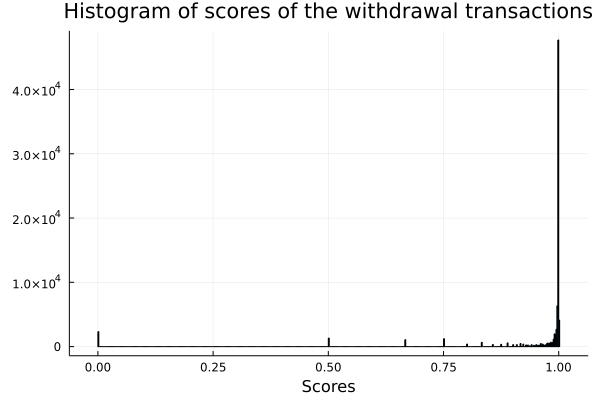

In [20]:
score_values = values(scores) |> collect
histogram(score_values, bins=500, legend=false, title="Histogram of scores of the withdrawal transactions", xlabel="Scores")